In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy.stats import pearsonr
%matplotlib inline

In [3]:
movie_dates_df = pd.read_csv('movie_release_dates.csv', index_col=0)
theaters_df = pd.read_csv('movie_theater_data.csv', index_col=0)
awards_df = pd.read_csv('movie_awards.csv', index_col=0)
actors_df = pd.read_csv('Actors_Table.csv')
directors_df = pd.read_csv('Directors_Table.csv')
imdb_base_df = pd.read_csv('IMDb_base.csv')
imdb_budgets_df = pd.read_csv('IMDb_budgets.csv')

In [4]:
#First remove any movies that had a $0 domestic gross.
imdb_budgets_df = imdb_budgets_df[imdb_budgets_df['Domestic Gross'] !=0]

First we start by adjusting the production budget, worldwide gross, and domestic gross for inflation, at an average yearly inflation rate of 3.22%.

In [5]:
#Find the inflation rate.
imdb_budgets_df['Production Budget'] = (((2020-imdb_budgets_df['Year'])*.0322)+1)*imdb_budgets_df['Production Budget']
imdb_budgets_df['Worldwide Gross'] = (((2020-imdb_budgets_df['Year'])*.0322)+1)*imdb_budgets_df['Worldwide Gross']
imdb_budgets_df['Domestic Gross'] = (((2020-imdb_budgets_df['Year'])*.0322)+1)*imdb_budgets_df['Domestic Gross']

Next we want to find the net profit and profit margin for each movie to determine profitability.

In [6]:
#Find the net profit and profit margin.
imdb_budgets_df['Net Profit'] = imdb_budgets_df['Worldwide Gross'] - imdb_budgets_df['Production Budget']
imdb_budgets_df['Profit Margin'] = imdb_budgets_df['Net Profit'] / imdb_budgets_df['Worldwide Gross']

In [7]:
#Create a genre table that separates each value in the genre column in their own rows.
imdb_budgets_df['Genre'] = imdb_budgets_df['Genre'].str.split(', ')
imdb_budgets_df1 = imdb_budgets_df['Genre'].apply(pd.Series)
imdb_budgets_df2 = pd.merge(imdb_budgets_df, imdb_budgets_df1, right_index = True, left_index = True)
imdb_budgets_df3 = imdb_budgets_df2.drop(['Genre'], axis = 1)
genre_budgets_df = imdb_budgets_df3.melt(id_vars=['Movie', 'Year'], value_vars=[0, 1, 2] ,var_name = ['X'])
genre_budgets_df = pd.merge(genre_budgets_df, imdb_budgets_df)
genre_budgets_df = genre_budgets_df.drop(['Genre', 'X'], axis=1)
genre_budgets_df = genre_budgets_df.drop_duplicates()
genre_budgets_df = genre_budgets_df.rename(columns={'value': 'Genre'})
genre_budgets_df = genre_budgets_df.dropna()

# Question 2: Which movie genres are most commonly produced and does quantity equate to higher net profits?

Let's start by determing which genres are the most common among the movies in our dataset. (Note: Most movies fall under multiple genres)

In [162]:
#Do a count of all movies grouped by genre.
m_by_genre = genre_budgets_df.groupby('Genre', as_index=False)['Movie'].count().sort_values(by='Movie', ascending=False)

In [163]:
m_by_genre

,Genre,Movie
6,Drama,1876
4,Comedy,1444
0,Action,1045
1,Adventure,834
5,Crime,689
15,Romance,622
18,Thriller,615
11,Horror,410
14,Mystery,356
16,Sci-Fi,330


[Text(0.5, 1.0, 'Movie Count by Genre')]

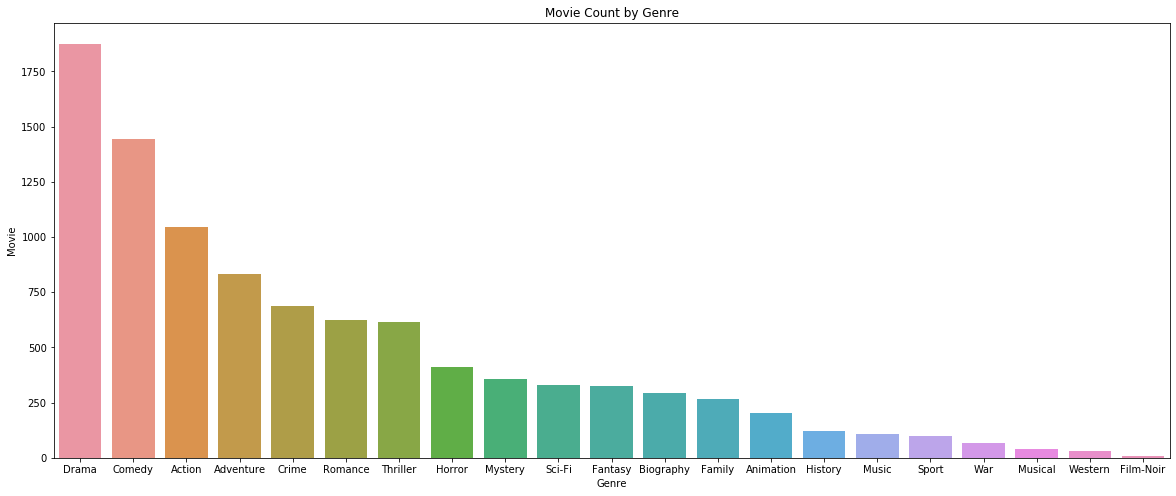

In [164]:
#Plot the above findings.
plt.figure(figsize=(20,8))
ax1 = sns.barplot(x=m_by_genre['Genre'], y=m_by_genre['Movie'])
ax1.set(title='Movie Count by Genre')

We can see that drama, comedy, and action dominate the quantity of movie genres but does this necessarily mean these are the most profitable genres? In order to determine this we will once again group each genre but this time we are going to take a look at the average net profit for each.

In [201]:
#Once again group the movies by genre, showing the average net profit and profit margin for each.
p_by_genre = genre_budgets_df.groupby('Genre', as_index=False)['Net Profit', 'Profit Margin'].median().sort_values(by='Net Profit', ascending=False)


In [202]:
p_by_genre

,Genre,Net Profit,Profit Margin
2,Animation,2.036066e+08,0.681316
1,Adventure,1.237950e+08,0.610306
16,Sci-Fi,7.619912e+07,0.596241
7,Family,7.462154e+07,0.582691
0,Action,6.433253e+07,0.519977
8,Fantasy,5.405758e+07,0.542261
18,Thriller,4.733895e+07,0.595092
13,Musical,4.663190e+07,0.652690
14,Mystery,3.963432e+07,0.614036
11,Horror,3.896335e+07,0.670497


[Text(0, 0.5, 'Genre'),
 Text(0.5, 0, 'Net Profit(Hundreds of Millions)'),
 Text(0.5, 1.0, 'Net Profit By Genre')]

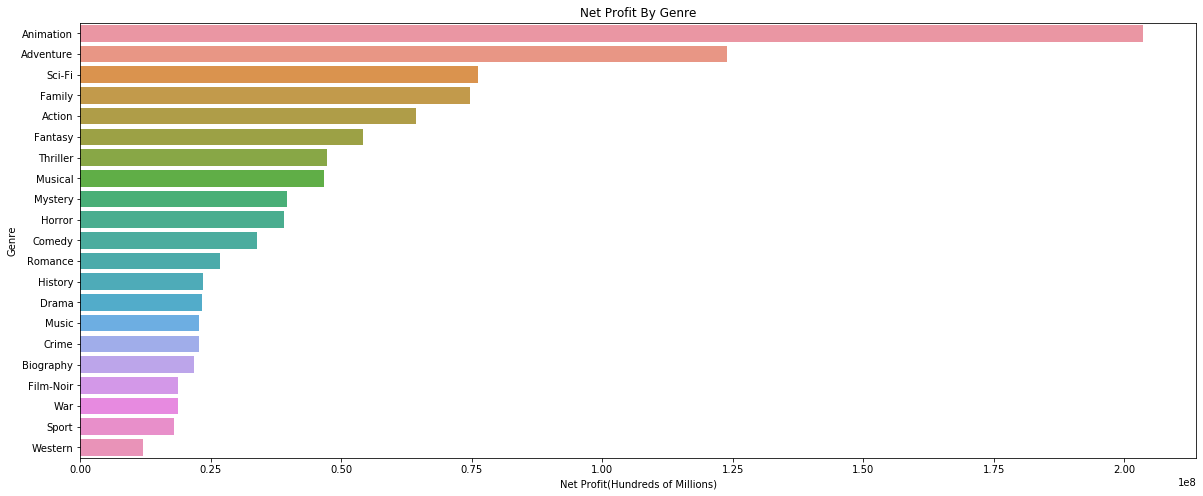

In [206]:
#Plot the above findings.
plt.figure(figsize=(20,8))
ax2 = sns.barplot(x=p_by_genre['Net Profit'], y=p_by_genre['Genre'])
ax2.set(xlabel='Net Profit(Hundreds of Millions)', ylabel='Genre', title='Net Profit By Genre')

(0.3, 0.85)

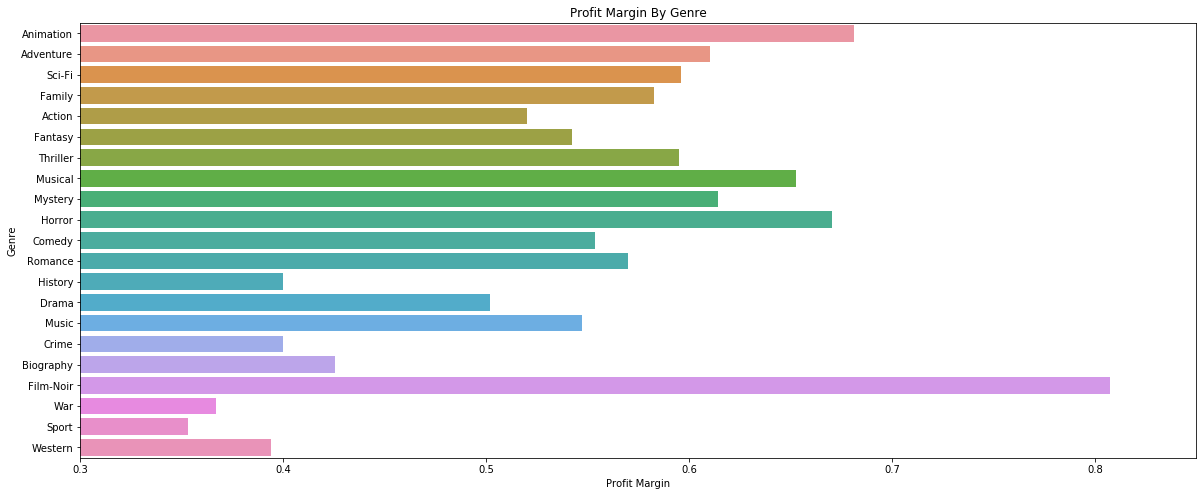

In [230]:
plt.figure(figsize=(20,8))
ax12 = sns.barplot(x=p_by_genre['Profit Margin'], y=p_by_genre['Genre'])
ax12.set(xlabel='Profit Margin', ylabel='Genre', title='Profit Margin By Genre')
plt.xlim(0.3, 0.85)

Interesting, although they are not the most commonly released genres; animation, adventure, and sci-fi typically have the most success in terms of median net profit. We can also see that Animation has a desirable profit margin along with horror and musicals. Note: although Film Noir leads with a .8+ profit margin this is based on 6 movies and has to be disregarded due to the small sample size. 

Lastly, of what percentage of the total net profit from all genres does each genre account?

In [168]:
#Grouped by genre, find the percent total of the net profit for each.
per_by_genre = genre_budgets_df.groupby(['Genre'],  as_index=False)['Net Profit'].sum().sort_values(by='Net Profit', ascending=False)
per_by_genre['Percent Total of Net Profit'] = (per_by_genre['Net Profit']/per_by_genre['Net Profit'].sum()*100).round(2)
per_by_genre

,Genre,Net Profit,Percent Total of Net Profit
1,Adventure,2.173357e+11,18.07
0,Action,1.789300e+11,14.88
4,Comedy,1.519229e+11,12.63
6,Drama,1.449900e+11,12.05
16,Sci-Fi,7.046561e+10,5.86
2,Animation,6.872099e+10,5.71
18,Thriller,6.544224e+10,5.44
8,Fantasy,5.479714e+10,4.56
15,Romance,5.051074e+10,4.20
7,Family,4.604064e+10,3.83


[Text(0.5, 1.0, 'Percent of Net Profit By Genre')]

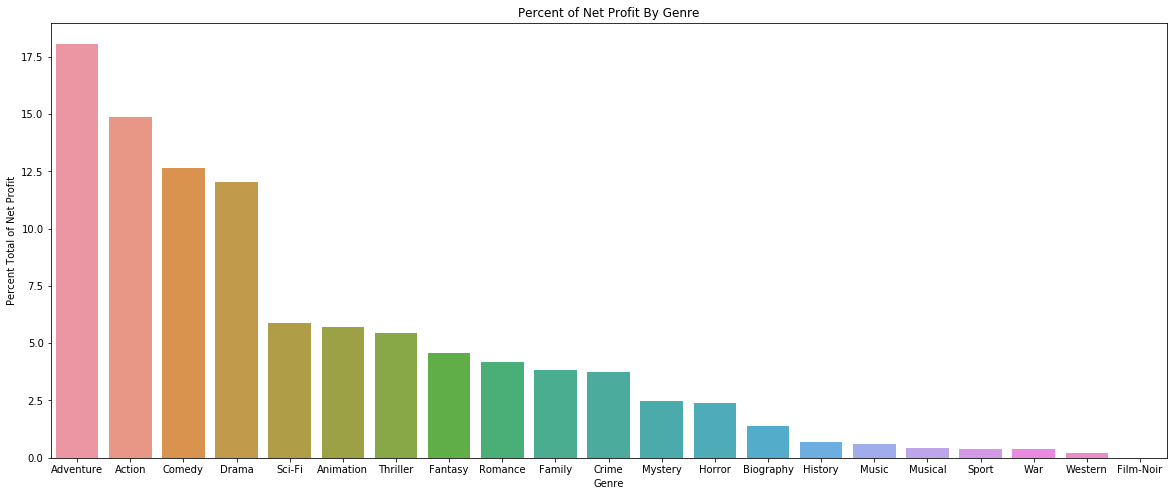

In [169]:
#Plot the above findings.
plt.figure(figsize=(20,8))
ax3 = sns.barplot(x=per_by_genre['Genre'], y=per_by_genre['Percent Total of Net Profit'])
ax3.set(title='Percent of Net Profit By Genre')

Now we can see that adventure, action, comedy and drama make up the lionshare of the overall net profits from all movies. However, from our recent observations we know there are also major opportunities in the animation and sci-fi markets due to lower saturation but high average net profits. We will soon determine which genres are most successful during which months.

# Question 3: What is the best time of the year to release a movie?

In [170]:
#Convert the Release Date field to type datetime.
imdb_budgets_df['Release Date'] = pd.to_datetime(imdb_budgets_df['Release Date'])

In [171]:
#Add a new column called month, displaying only the month from the release date.
dateData =  [x.strftime('%B') for x in imdb_budgets_df['Release Date']]
imdb_budgets_df['Month'] = dateData

Let's first start by determing which months see the most movie releases.

In [172]:
#Count the total number of movies and group by month.
m_by_month = imdb_budgets_df.groupby(['Month'], as_index=False)['Movie'].count().sort_values(by='Movie', ascending=False)
m_by_month

,Month,Movie
2,December,452
10,October,424
9,November,366
11,September,358
1,August,346
6,June,327
5,July,296
7,March,270
8,May,241
0,April,238


[Text(0, 0.5, 'Count'), Text(0.5, 1.0, 'Count of Movie Release By Month')]

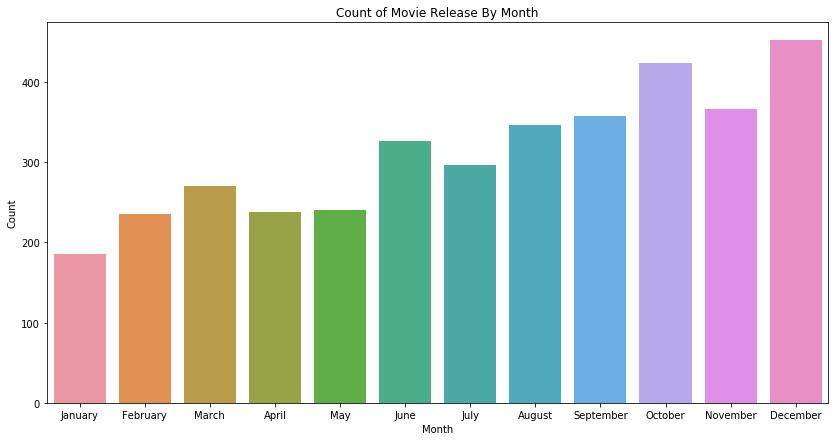

In [173]:
#Plot the above findings in order by month.
plt.figure(figsize=(14,7))
ax4 = sns.countplot(x=imdb_budgets_df['Month'],
                   order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ax4.set(ylabel='Count', title='Count of Movie Release By Month')

As you can see Decemeber and October lead the way in terms of sheer quantity of movies but does this suggest a higher level of profitability? Next we will look into the average net income by movie for each month.

In [197]:
#Once again group the movies by month, showing the average net profit for each.
p_by_month = imdb_budgets_df.groupby('Month', as_index=False)['Net Profit', 'Profit Margin'].median().sort_values(by='Net Profit', ascending=False)
p_by_month

,Month,Net Profit,Profit Margin
6,June,8.032764e+07,0.642956
8,May,7.937216e+07,0.638093
5,July,7.471662e+07,0.644061
2,December,5.682309e+07,0.587273
9,November,4.747665e+07,0.571790
3,February,4.108945e+07,0.563982
7,March,3.364581e+07,0.514524
0,April,3.143564e+07,0.541053
4,January,3.113234e+07,0.555721
1,August,2.538331e+07,0.522294


[Text(0, 0.5, 'Net Profit(Tens of Millions)'),
 Text(0.5, 1.0, 'Median Movie Net Profit By Release Month')]

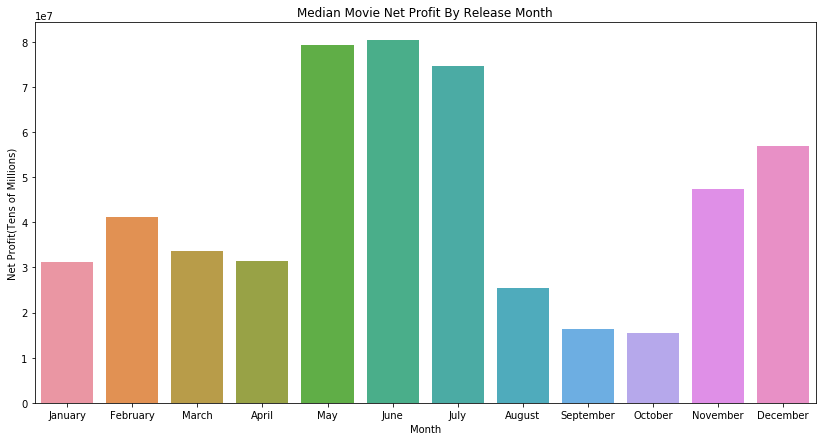

In [200]:
#Plot your above findings in order by month.
plt.figure(figsize=(14,7))
ax5 = sns.barplot(x=p_by_month['Month'], y=p_by_month['Net Profit'], 
                  order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ax5.set(ylabel='Net Profit(Tens of Millions)', title='Median Movie Net Profit By Release Month')


(0.3, 0.7)

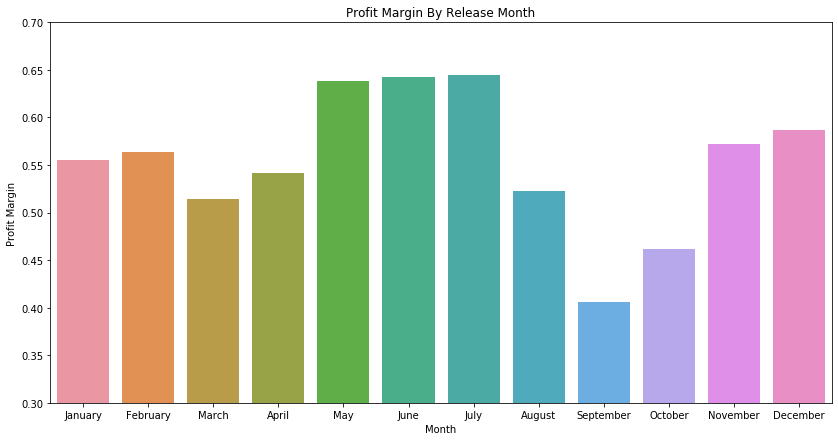

In [229]:
plt.figure(figsize=(14,7))
ax15 = sns.barplot(x=p_by_month['Month'], y=p_by_month['Profit Margin'], 
                  order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ax15.set(ylabel='Profit Margin', title='Profit Margin By Release Month')
plt.ylim(0.3, 0.7)

Interestingly, May, June and July shoot to the top in terms of both median net profit and profit margin. It appears that the summer months tend to result in greater success, perhaps as a result of an influx of children and their parents during summer break. Now as previously mentioned, let's dig a little further and see which genre tends to do the best in which month.

In [176]:
#Convert the Release Date field to type datetime
#Add a new column called month, displaying only the month from the release date.
genre_budgets_df['Release Date'] = pd.to_datetime(genre_budgets_df['Release Date'])
genreDate =  [x.strftime('%B') for x in genre_budgets_df['Release Date']]
genre_budgets_df['Month'] = genreDate

In [177]:
#Create a new table called month_genre consisting of Genre, Month, Net Profit, and Release Date
month_genre = genre_budgets_df[['Genre', 'Month', 'Net Profit', 'Release Date']]
#Group by Genre and Month, displaying the average Net Profit for each combination.
month_genre = month_genre.groupby(['Genre', 'Month'], as_index=False)['Net Profit'].mean().sort_values(by='Net Profit', ascending=False)

In [178]:
#Slice the top six most profitable genres from above.
Adventure_df = month_genre.loc[month_genre['Genre'].str.contains('Adventure')]
Action_df = month_genre.loc[month_genre['Genre'].str.contains('Action')]
Comedy_df = month_genre.loc[month_genre['Genre'].str.contains('Comedy')]
Drama_df = month_genre.loc[month_genre['Genre'].str.contains('Drama')]
Scifi_df = month_genre.loc[month_genre['Genre'].str.contains('Sci-Fi')]
Animation_df = month_genre.loc[month_genre['Genre'].str.contains('Animation')]

In [179]:
#Concatenate the six new tables into one new table.
genre_concat = [Adventure_df, Action_df, Comedy_df, Drama_df, Scifi_df, Animation_df]
month_genre_df = pd.concat(genre_concat)

In [180]:
#Create a table of the months in order.
months_in_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
#Create a pivot table of month_genre_df, use the month_in_order table to reindex the pivot table.
month_genre_pivoted = month_genre_df.pivot(index='Month', columns='Genre', values='Net Profit').reindex(months_in_order)

In [181]:
month_genre_pivoted

Genre,Action,Adventure,Animation,Comedy,Drama,Sci-Fi
Month,,,,,,
January,6.791123e+07,1.014803e+08,2.543046e+08,7.032172e+07,4.353902e+07,8.613114e+07
February,1.077412e+08,1.491730e+08,2.736999e+08,7.812990e+07,6.380754e+07,1.234631e+08
March,1.275490e+08,2.004747e+08,2.402952e+08,8.141113e+07,5.234813e+07,1.713357e+08
April,2.593924e+08,3.714263e+08,1.355146e+08,5.005051e+07,7.719929e+07,4.009927e+08
May,3.004318e+08,3.769460e+08,5.874762e+08,1.878399e+08,9.659074e+07,3.818387e+08
June,2.651015e+08,3.929636e+08,5.877637e+08,1.754166e+08,1.123821e+08,3.668735e+08
July,2.572935e+08,2.808123e+08,3.251843e+08,1.409271e+08,1.191990e+08,2.625137e+08
August,7.899352e+07,8.112804e+07,1.081159e+08,5.270262e+07,6.563711e+07,8.081201e+07
September,5.298018e+07,9.338847e+07,1.538475e+08,5.328869e+07,4.019450e+07,1.108048e+08


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

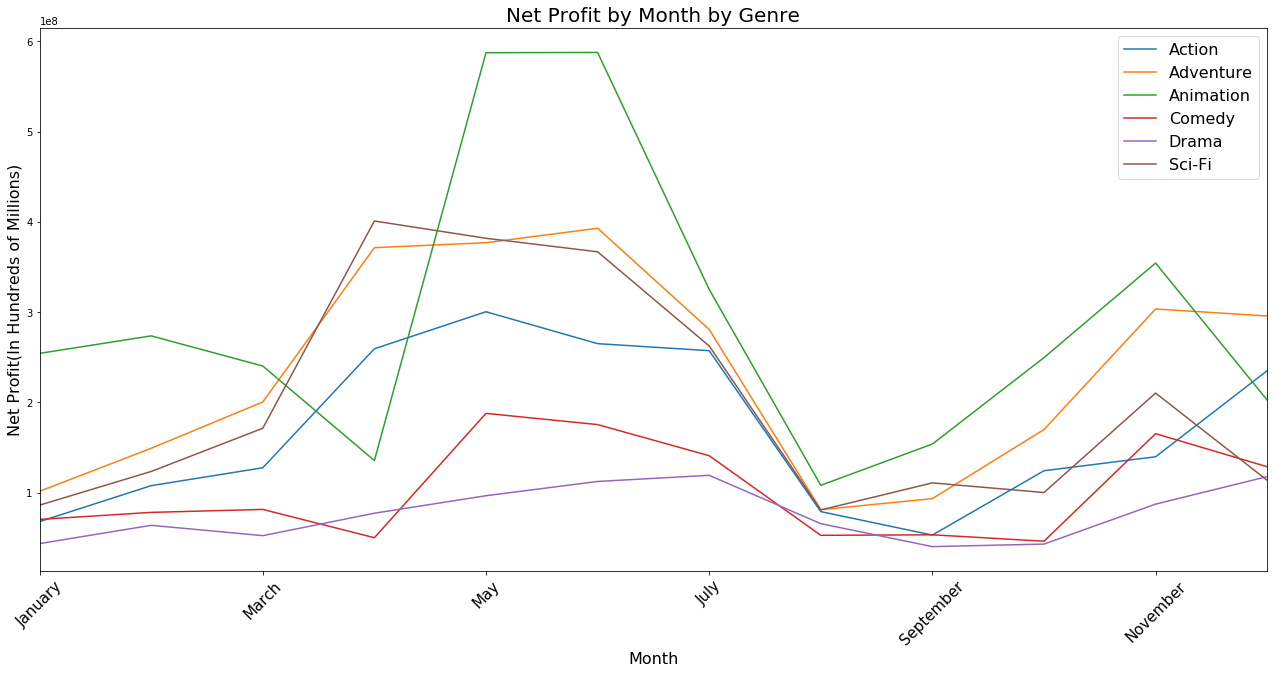

In [182]:
#Visualize the top 6 most profitable genre's by month
month_genre_pivoted.plot(kind='line', figsize=(22, 10), rot=0)
plt.legend(prop={'size': 16})
plt.xlabel('Month', fontsize=16)
plt.ylabel('Net Profit(In Hundreds of Millions)', fontsize=16)
plt.title('Net Profit by Month by Genre', fontsize=20)
plt.xticks(fontsize=15, rotation=45)

We can see that each genre follows the same basic pattern, with the summer months proving to be the most profitable time to release a movie. Some further analysis shows that releasing an animation movie in particular during the summer months will have the greatest potential for high net profits. On the other hand drama, although fluctuates slightly with the months, tends to have no impact based on release date. When considering what aspects go into creating a successful movie, it's clear that one must take take into account the impact of a well timed release date.

# Question 5: Now that we've got a better understanding of what attributes to a successful movie, which actors and directors tend to add the most value?

In this section we are going to take a look at the average net profit across all movies. From there we want to determine which actors and directors consistently appear in movies where the net profit substantially exceeds the average. We will represent this in a field called Value Above Replacement(VAR). To further simplify this concept; if across all movies the average net profit is 100 dollars and the average net profit of movies from 'Actor: X' is 200 dollars he/she would have a VAR of 2. This number represents X times over the average. To eliminate outliers we will look at actors who appear in 10 or more movies and directors who work in 5 or more.

In [183]:
#Similar to the imdb_budget_df table let's start by adjusting for inflation.
actors_df['Production Budget'] = (((2020-actors_df['Year'])*.0322)+1)*actors_df['Production Budget']
actors_df['Worldwide Gross'] = (((2020-actors_df['Year'])*.0322)+1)*actors_df['Worldwide Gross']
actors_df['Domestic Gross'] = (((2020-actors_df['Year'])*.0322)+1)*actors_df['Domestic Gross']

In [184]:
#Calculate Net Profit and Profit Margin
actors_df['Net Profit'] = actors_df['Worldwide Gross'] - actors_df['Production Budget']
actors_df['Profit Margin'] = actors_df['Net Profit'] / actors_df['Worldwide Gross']

In [185]:
#Let's filter the actors_df table to only include actors that appeared in 10 or more movies
actor_counts = actors_df['value'].value_counts()
actor_list = actor_counts[actor_counts >= 10].index.tolist()
actors_df = actors_df[actors_df['value'].isin(actor_list)]

In [186]:
#Calculate VAR, which is the average Net Profit by actor divided by average Net Profit for all movies.
actor_total = actors_df.groupby(['value'],  as_index=False)['Net Profit'].mean().sort_values(by='Net Profit', ascending=False)
actor_total['VAR'] = (actor_total['Net Profit']/actor_total['Net Profit'].mean())

In [187]:
#Create new table consisting of top 25 actors by VAR.
top_actors = actor_total.head(25)
top_actors

,value,Net Profit,VAR
113,Ian McKellen,6.426411e+08,4.562969
88,Emma Watson,5.940703e+08,4.218100
48,Chris Hemsworth,5.509931e+08,3.912237
47,Chris Evans,5.183979e+08,3.680800
262,Robert Downey Jr.,4.848850e+08,3.442847
82,Elijah Wood,4.684149e+08,3.325904
227,Mike Myers,4.516160e+08,3.206626
324,Zoe Saldana,4.184140e+08,2.970881
205,Mark Ruffalo,4.180517e+08,2.968308
166,Josh Hutcherson,3.899468e+08,2.768754


[Text(0, 0.5, 'Actor'), Text(0.5, 1.0, 'VAR By Actor Compared to Average')]

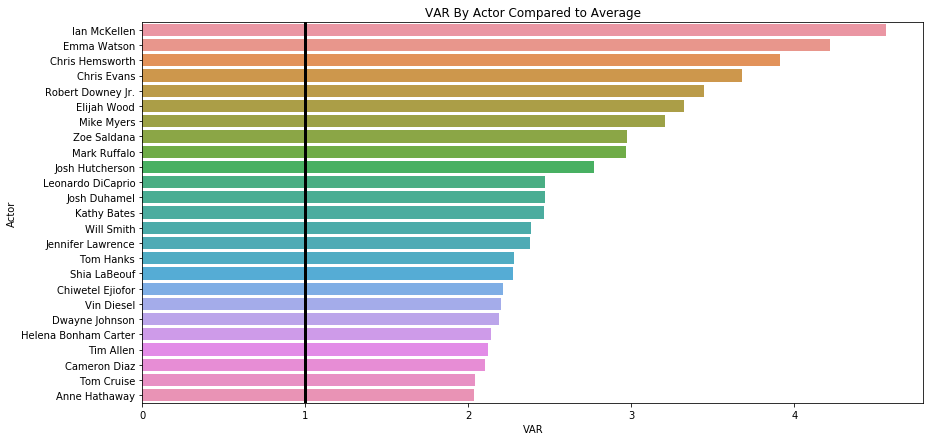

In [188]:
#Plot above finding and label the average of 1 with a black line.
plt.figure(figsize=(14,7))
ax6 = sns.barplot(x=top_actors['VAR'], y=top_actors['value'])
ax6.axvline(1, ls='-', color='black', linewidth=3)
ax6.set(ylabel='Actor', title='VAR By Actor Compared to Average')

Wow, from this list we can see that all of these actors consistently appear in very profitable movies; anywhere from two times the norm to four and a half times the norm. When casting a movie this is a good short-list from where to start making calls.

In [189]:
#Adjust directors table for inflation.
directors_df['Production Budget'] = (((2020-directors_df['Year'])*.0322)+1)*directors_df['Production Budget']
directors_df['Worldwide Gross'] = (((2020-directors_df['Year'])*.0322)+1)*directors_df['Worldwide Gross']
directors_df['Domestic Gross'] = (((2020-directors_df['Year'])*.0322)+1)*directors_df['Domestic Gross']

In [190]:
#Calucalte Net Profit and Profit Margin.
directors_df['Net Profit'] = directors_df['Worldwide Gross'] - directors_df['Production Budget']
directors_df['Profit Margin'] = directors_df['Net Profit'] / directors_df['Worldwide Gross']

In [191]:
#Let's filter the actors_df table to only include actors that appeared in 5 or more movies.
director_counts = directors_df['value'].value_counts()
director_list = director_counts[director_counts >= 5].index.tolist()
directors_df = directors_df[directors_df['value'].isin(director_list)]

In [192]:
#Calculate VAR, which is the average Net Profit by director divided by average Net Profit for all movies.
director_total = directors_df.groupby(['value'],  as_index=False)['Net Profit'].mean().sort_values(by='Net Profit', ascending=False)
director_total['VAR'] = (director_total['Net Profit']/actor_total['Net Profit'].mean())

In [193]:
#Create new table consisting of top 25 directors by VAR.
top_directors = director_total.head(25)
top_directors

,value,Net Profit,VAR
78,James Cameron,1.244750e+09,8.838147
11,Anthony Russo,1.017389e+09,7.223809
89,Joe Russo,1.017389e+09,7.223809
115,Lee Unkrich,9.120679e+08,6.475990
148,Peter Jackson,8.218780e+08,5.835612
50,David Yates,6.881352e+08,4.885993
104,Jon Favreau,6.287041e+08,4.464012
129,Michael Bay,5.888046e+08,4.180712
96,John Lasseter,5.772545e+08,4.098702
31,Christopher Nolan,5.765089e+08,4.093408


[Text(0, 0.5, 'Director'),
 Text(0.5, 1.0, 'VAR By Director Compared to Average')]

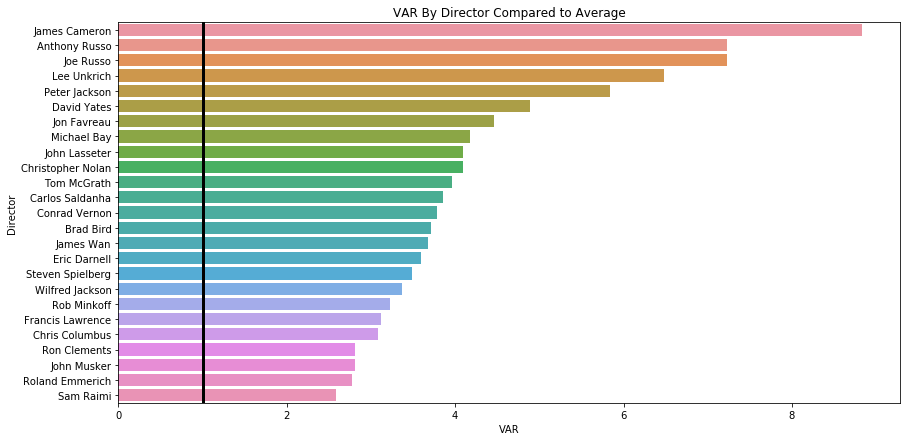

In [194]:
#Plot above finding and label the average of 1 with a black line.
plt.figure(figsize=(14,7))
ax7 = sns.barplot(x=top_directors['VAR'], y=top_directors['value'])
ax7.axvline(1, ls='-', color='black', linewidth=3)
ax7.set(ylabel='Director', title='VAR By Director Compared to Average')

It appears that the most significant value added comes from the directors chair. James Cameron movies on average make almost nine times the amount of the average movie, this emphasizes what great leadership represents on a set.

If we had more time we could determine which genre each actor and director find the most success.